# Importe

In [ ]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point
from shapely.ops import transform
from pyproj import Transformer
import contextily as ctx
import numpy as np
from shapely.strtree import STRtree
from tqdm import tqdm

# Import Einwohnerdichte 2023

In [ ]:
# EINWOHNERDICHTE_URL = "https://gdi.berlin.de/services/wfs/ua_einwohnerdichte_2023?SERVICE=WFS&VERSION=2.0.0&REQUEST=GetFeature&TYPENAMES=ua_einwohnerdichte_2023:einwohnerdichte2023&OUTPUTFORMAT=application/json"

# response = requests.get(EINWOHNERDICHTE_URL)
# data = response.json()

# records = []
# for feature in data['features']:
#     record = feature['properties'].copy()
#     record['coordinates'] = feature['geometry']['coordinates']
#     records.append(record)

# df = pd.DataFrame(records)
# df.head()
# df.to_csv("../input/raw/einwohnerdichte.csv", index=False)

| Column        | Description |
| ------------- | ------------- |
| schluessel  | Eindeutiger Schlüssel der ISU5-Fläche 1 : 5.000 |
| ew2023     | Anzahl Einwohner > 2 |
| flalle     | Flächengröße [m²] |
| ha     | Flächengröße der ISU5-Fläche |
| ew_ha_2023         | Einwohner pro Hektar  |
| alter_u6       | Anzahl der Einwohner (> 2), die jünger als 6 Jahre sind |
| alter_6_u10     | Anzahl der Einwohner (> 2), die 6 bis unter 10 Jahre alt sind |
| alter_10_u18    | Anzahl der Einwohner (> 2), die 10 bis unter 18 Jahre alt sind  |
| alter_18_u65  | Anzahl der Einwohner (> 2), die 18 bis unter 65 Jahre alt sind |
| alter_65_u70    | Anzahl der Einwohner (> 2), die 65 bis unter 70 Jahre alt sind |
| alter_70_u75     | Anzahl der Einwohner (> 2), die 70 bis unter 75 Jahre alt sind |
| alter75_u80  | Anzahl der Einwohner (> 2), die 75 bis unter 80 Jahre alt sind |
| alter_80plus    | Anzahl der Einwohner (> 2), die 80 Jahre alt oder älter sind |
| typklar  | Es werden 52 verschiedene Flächentypen unterschieden. Im Gegensatz zu den Nutzungen GRZ und WOZ wird hier besonders Wert auf eine differenzierte Darstellung der baulichen Nutzungen gelegt, die stadtstrukturell (Siedlungstyp, Alter etc.)  unterschieden werden. Die Flächentypen werden auch zur Zuordnung weitererer Indikatoren verwendet (Belagsklassen der Versiegelung, Kanalisation) |
| etypklar    | typklar in Englisch |
| coordinates  | Die Koordianten aus dem MultiPolygon|

In [2]:
df_einwohnerdichte = pd.read_csv("../input/raw/einwohnerdichte_2023.csv")
df_einwohnerdichte.head()

,schluessel,ew2023,flalle,ha,ew_ha_2023,alter_u6,alter_6_u10,alter_10_u18,alter_18_u65,alter_65_u70,alter_70_u75,alter75_u80,alter_80plus,typklar,etypklar,coordinates
0,100980011000100,0,4623.97,0.46,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Freie Zeilenbebauung mit landschaftlichem Sied...,"Free row development, landscaped residential g...","[[[[389424.8486, 5821759.519], [389373.1201, 5..."
1,100980011000200,0,13430.94,1.34,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parkplatz,Parking area,"[[[[389424.8486, 5821759.519], [389336.994, 58..."
2,100980011000300,20,5603.76,0.56,35.69,0.0,0.0,3.0,17.0,0.0,0.0,0.0,0.0,Geschosswohnungsbau der 1990er Jahre und jünger,Rental-flat buildings of the 1990s and later,"[[[[389326.3188, 5821907.8433], [389287.3293, ..."
3,100980021000200,876,34344.73,3.43,255.06,62.0,29.0,70.0,648.0,18.0,25.0,12.0,12.0,"Heterogene, innerstädtische Mischbebauung, Lüc...","Heterogeneous inner-city mixed development, po...","[[[[389743.2547, 5822026.1252], [389703.0457, ..."
4,100980021000300,0,48930.21,4.89,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Krankenhaus,Hospital,"[[[[389693.5778, 5821875.268], [389605.7562, 5..."


In [3]:
df_einwohnerdichte.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26422 entries, 0 to 26421
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   schluessel    26422 non-null  int64  
 1   ew2023        26422 non-null  int64  
 2   flalle        26422 non-null  float64
 3   ha            26422 non-null  float64
 4   ew_ha_2023    26422 non-null  float64
 5   alter_u6      15434 non-null  float64
 6   alter_6_u10   15434 non-null  float64
 7   alter_10_u18  15434 non-null  float64
 8   alter_18_u65  15434 non-null  float64
 9   alter_65_u70  15434 non-null  float64
 10  alter_70_u75  15434 non-null  float64
 11  alter75_u80   15434 non-null  float64
 12  alter_80plus  15434 non-null  float64
 13  typklar       26422 non-null  object 
 14  etypklar      26422 non-null  object 
 15  coordinates   26422 non-null  object 
dtypes: float64(11), int64(2), object(3)
memory usage: 3.2+ MB


In [4]:
missing_counts = df_einwohnerdichte.isnull().sum().sort_values(ascending=False)
missing_counts

alter_u6        10988
alter_6_u10     10988
alter_10_u18    10988
alter_18_u65    10988
alter_65_u70    10988
alter_70_u75    10988
alter75_u80     10988
alter_80plus    10988
schluessel          0
ew2023              0
flalle              0
ha                  0
ew_ha_2023          0
typklar             0
etypklar            0
coordinates         0
dtype: int64

In [5]:
df_einwohnerdichte["coordinates"][1]

'[[[[389424.8486, 5821759.519], [389336.994, 5821892.5415], [389326.3188, 5821907.8433], [389261.9648, 5821859.5618], [389326.2138, 5821756.2912], [389344.8057, 5821767.5143], [389373.1201, 5821725.6635], [389424.8486, 5821759.519]]]]'

EPSG:25833

In [6]:
df_gewerbedaten = pd.read_csv("../input/clean/ihk_gewerbedaten_with_brw.csv")
df_gewerbedaten.head()

,opendata_id,city,postcode,latitude,longitude,ihk_branch_id,employees_range,ihk_branch_desc,business_age,business_type,Bezirk,planungsraum_id,Planungsraum,Bezirksregion,Prognoseraum,Ortsteil,employees_numerical,gründungsjahr,Bodenrichtwert
0,572114,Berlin,10179,52.513315,13.411584,65122.0,0 Beschäftigte,Schaden- u. Unfallversicherungen,40.0,Kleingewerbetreibender,Mitte,1100312.0,Heine-Viertel West,Alexanderplatz,Zentrum,Mitte,0.0,1985,4500.0
1,6063606,Berlin,10713,52.488737,13.302834,562900.0,0 Beschäftigte,Kantinen,41.0,Kleingewerbetreibender,Charlottenburg-Wilmersdorf,4500939.0,Eisenzahnstraße,Halensee,Wilmersdorf Zentrum,Wilmersdorf,0.0,1984,4000.0
2,131831318,Berlin,10713,52.479296,13.319051,47430.0,0 Beschäftigte,EH m. Geräten der Unterhaltungselektronik,40.0,Kleingewerbetreibender,Charlottenburg-Wilmersdorf,4501148.0,Brabanter Platz,Volkspark Wilmersdorf,Wilmersdorf Zentrum,Wilmersdorf,0.0,1985,2900.0
3,943032071440,Berlin,12047,52.486200,13.429312,731108.0,0 Beschäftigte,"Promotion, Propagandisten",13.0,im Handelsregister eingetragen,Neukölln,8100314.0,Donaustraße,Reuterstraße,Neukölln,Neukölln,0.0,2012,650.0
4,927439271464,Berlin,12435,52.492207,13.451324,451103.0,1 - 3 Beschäftigte,"EH m. Elektro-, Gas- u. Hybridfahrzeugen",10.0,Kleingewerbetreibender,Treptow-Köpenick,9100101.0,Alt-Treptow,Alt-Treptow,Treptow-Köpenick 1,Alt-Treptow,2.0,2015,5000.0


Transformierte Koordinate: 392209.59, 5819318.79
Passender Eintrag gefunden in Zeile 465 mit Schlüssel: 101040141000000


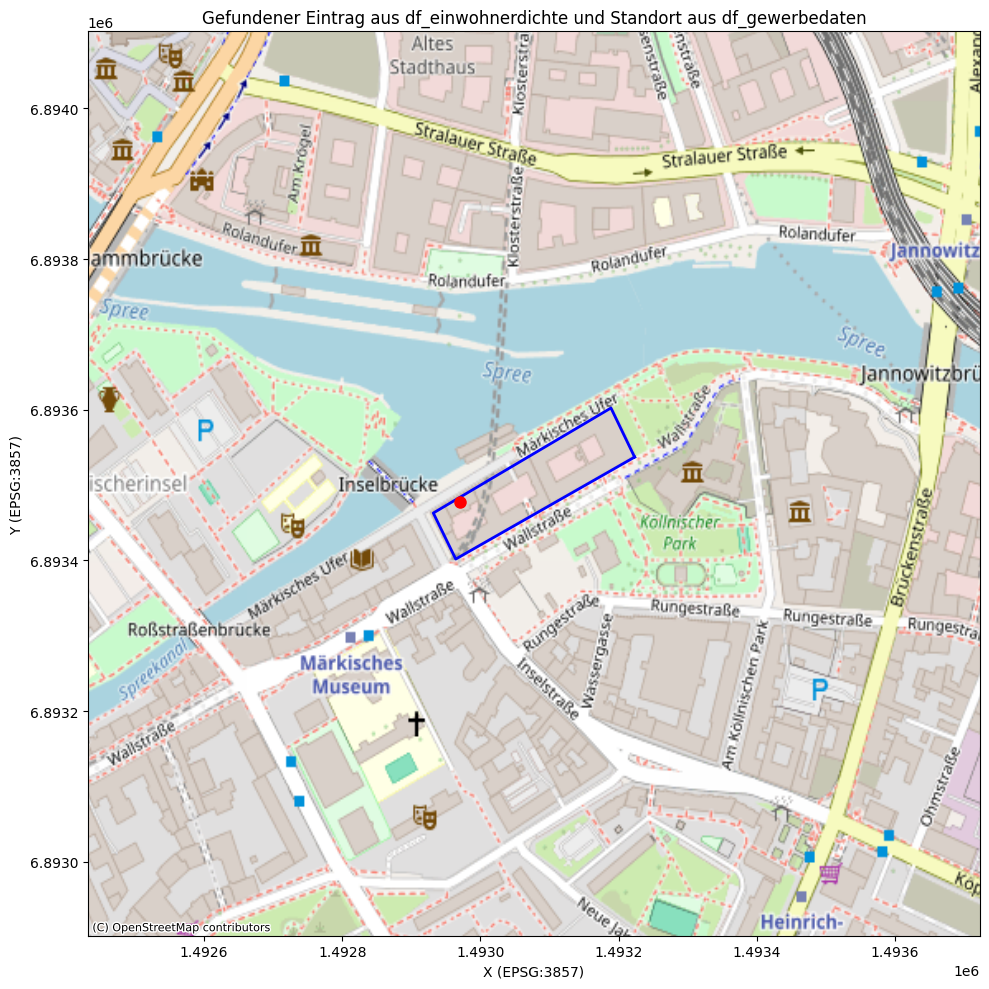

In [7]:
# --- Schritt 1: Beispielpunkt aus df_gewerbedaten ---
# Nehme die erste Zeile aus df_gewerbedaten (EPSG:4326)
row_gewerbe = df_gewerbedaten.iloc[0]
lon, lat = row_gewerbe["longitude"], row_gewerbe["latitude"]

# Transformiere die Koordinaten von EPSG:4326 zu EPSG:25833
transformer_25833 = Transformer.from_crs("EPSG:4326", "EPSG:25833", always_xy=True)
x, y = transformer_25833.transform(lon, lat)
point = Point(x, y)
print(f"Transformierte Koordinate: {point.x:.2f}, {point.y:.2f}")

# --- Schritt 2: Finde in df_einwohnerdichte einen passenden Eintrag ---
# Filtere nur Zeilen mit gültigen 'coordinates'
df_einwohnerdichte_valid = df_einwohnerdichte[df_einwohnerdichte["coordinates"].notnull()]

matching_polygon = None
for idx, row in df_einwohnerdichte_valid.iterrows():
    try:
        # Falls der Inhalt bereits eine Liste ist, packe ihn in ein Dictionary
        coord_val = row["coordinates"]
        if isinstance(coord_val, list):
            geojson = {"type": "MultiPolygon", "coordinates": coord_val}
        else:
            geojson = json.loads(coord_val)
            if isinstance(geojson, list):
                geojson = {"type": "MultiPolygon", "coordinates": geojson}
        polygon = shape(geojson)
        if polygon.contains(point):
            matching_polygon = polygon
            print(f"Passender Eintrag gefunden in Zeile {idx} mit Schlüssel: {row['schluessel']}")
            break
    except Exception as e:
        print(f"Fehler beim Parsen in Zeile {idx}: {e}")
        continue

# --- Schritt 3: Reprojiziere die Geometrien von EPSG:25833 nach EPSG:3857 für die Basiskarte ---
transformer_to_3857 = Transformer.from_crs("EPSG:25833", "EPSG:3857", always_xy=True).transform
polygon_3857 = transform(transformer_to_3857, matching_polygon)
point_3857 = transform(transformer_to_3857, point)

# --- Schritt 4: Erstelle den Plot mit Kartenhintergrund ---
fig, ax = plt.subplots(figsize=(10, 10))

# Zeichne das Polygon (MultiPolygon oder Polygon)
if polygon_3857.geom_type == 'MultiPolygon':
    for poly in polygon_3857.geoms:
        x_poly, y_poly = poly.exterior.xy
        ax.plot(x_poly, y_poly, color='blue', linewidth=2)
else:
    x_poly, y_poly = polygon_3857.exterior.xy
    ax.plot(x_poly, y_poly, color='blue', linewidth=2)

# Zeichne den Punkt
ax.plot(point_3857.x, point_3857.y, 'ro', markersize=8)

ax.set_title("Gefundener Eintrag aus df_einwohnerdichte und Standort aus df_gewerbedaten")
ax.set_xlabel("X (EPSG:3857)")
ax.set_ylabel("Y (EPSG:3857)")

# Passe den Plotbereich an (Puffer hinzufügen)
minx, miny, maxx, maxy = polygon_3857.bounds
ax.set_xlim(minx - 500, maxx + 500)
ax.set_ylim(miny - 500, maxy + 500)

# Füge eine Basiskarte (OpenStreetMap) hinzu
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik)

plt.tight_layout()
plt.show()

In [8]:
# # Liste der Eigenschaften, die übertragen werden sollen:
# props = ["ew2023", "flalle", "ha", "ew_ha_2023", 
#          "alter_u6", "alter_6_u10", "alter_10_u18", "alter_18_u65", 
#          "alter_65_u70", "alter_70_u75", "alter75_u80", "alter_80plus", 
#          "typklar"]

# # Füge in df_gewerbedaten die neuen Spalten (initial mit NaN) hinzu:
# for prop in props:
#     df_gewerbedaten[prop] = np.nan

# # --- Schritt 1: Geometrien in df_einwohnerdichte parsen ---
# # Filtere nur Zeilen mit gültigen "coordinates"
# df_einwohnerdichte_valid = df_einwohnerdichte[df_einwohnerdichte["coordinates"].notnull()].copy()

# def parse_geometry(coord_val):
#     """Wandelt den Inhalt der Spalte 'coordinates' in ein Shapely-Objekt um."""
#     if isinstance(coord_val, list):
#         # Falls es schon eine Liste ist, packe sie in ein GeoJSON-Dict
#         return shape({"type": "MultiPolygon", "coordinates": coord_val})
#     try:
#         parsed = json.loads(coord_val)
#         if isinstance(parsed, list):
#             return shape({"type": "MultiPolygon", "coordinates": parsed})
#         else:
#             return shape(parsed)
#     except Exception as e:
#         return None

# df_einwohnerdichte_valid["geom_obj"] = df_einwohnerdichte_valid["coordinates"].apply(parse_geometry)
# df_einwohnerdichte_valid = df_einwohnerdichte_valid[df_einwohnerdichte_valid["geom_obj"].notnull()]

# # Erzeuge eine Liste der Geometrien und baue den STRtree
# geoms = df_einwohnerdichte_valid["geom_obj"].tolist()
# tree = STRtree(geoms)

# # Erstelle ein Mapping von der ID der Geometrie zu ihrem Index
# geom_index = {id(geom): idx for idx, geom in enumerate(geoms)}

# # --- Schritt 2: Transformation und Matching in df_gewerbedaten ---
# transformer_25833 = Transformer.from_crs("EPSG:4326", "EPSG:25833", always_xy=True)

# # Iteriere über alle Zeilen in df_gewerbedaten – mit Progress Bar
# for i, row in tqdm(df_gewerbedaten.iterrows(), total=len(df_gewerbedaten), desc="Matching Gewerbedaten"):
#     lon, lat = row["longitude"], row["latitude"]
#     x, y = transformer_25833.transform(lon, lat)
#     pt = Point(x, y)
    
#     # Suche Kandidaten im STRtree
#     candidates = tree.query(pt)
#     matched = False
#     for candidate in candidates:
#         # Falls der Kandidat ein Index ist, holen wir den Kandidaten aus der Liste
#         if isinstance(candidate, (int, np.integer)):
#             candidate_geom = geoms[candidate]
#             idx_candidate = candidate
#         else:
#             candidate_geom = candidate
#             idx_candidate = geom_index.get(id(candidate_geom))

#         if candidate_geom and candidate_geom.contains(pt):
#             candidate_row = df_einwohnerdichte_valid.iloc[idx_candidate]
#             for prop in props:
#                 df_gewerbedaten.at[i, prop] = candidate_row.get(prop, np.nan)
#             matched = True
#             break
#     if not matched:
#         # Falls kein passendes Polygon gefunden wurde, bleiben die neuen Spalten NaN
#         continue

# # Kontrolle: Zeige einige Zeilen mit den neuen Spalten
# df_gewerbedaten[["longitude", "latitude"] + props].head()

Matching Gewerbedaten:   0%|          | 0/353887 [00:00<?, ?it/s]/var/folders/0c/r0htcd1j05v_lb53s4xtzbn80000gn/T/ipykernel_6480/2464063175.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Kerngebiet' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_gewerbedaten.at[i, prop] = candidate_row.get(prop, np.nan)
Matching Gewerbedaten: 100%|██████████| 353887/353887 [00:34<00:00, 10240.15it/s]


,longitude,latitude,ew2023,flalle,ha,ew_ha_2023,alter_u6,alter_6_u10,alter_10_u18,alter_18_u65,alter_65_u70,alter_70_u75,alter75_u80,alter_80plus,typklar
0,13.411584,52.513315,47.0,7746.10,0.77,60.68,0.0,0.0,12.0,22.0,0.0,0.0,13.0,0.0,Kerngebiet
1,13.302834,52.488737,0.0,45915.33,4.59,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Verwaltung
2,13.319051,52.479296,967.0,19832.12,1.98,487.59,59.0,33.0,63.0,668.0,40.0,27.0,34.0,43.0,"Geschlossene Blockbebauung, Hinterhof (1870er ..."
3,13.429312,52.486200,254.0,3813.11,0.38,666.12,18.0,3.0,22.0,202.0,3.0,0.0,3.0,3.0,"Geschlossene Blockbebauung, Hinterhof (1870er ..."
4,13.451324,52.492207,0.0,58351.53,5.84,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Gewerbe- und Industriegebiet, großflächiger Ei..."


In [ ]:
# df_gewerbedaten.to_csv("../input/raw/ihk_gewerbedaten_with_brw_einwohnerdichte.csv", index=False)

In [10]:
df_gewerbedaten = pd.read_csv("../input/raw/ihk_gewerbedaten_with_brw_einwohnerdichte.csv")

In [11]:
df_gewerbedaten.head()

,opendata_id,city,postcode,latitude,longitude,ihk_branch_id,employees_range,ihk_branch_desc,business_age,business_type,...,ew_ha_2023,alter_u6,alter_6_u10,alter_10_u18,alter_18_u65,alter_65_u70,alter_70_u75,alter75_u80,alter_80plus,typklar
0,572114,Berlin,10179,52.513315,13.411584,65122.0,0 Beschäftigte,Schaden- u. Unfallversicherungen,40.0,Kleingewerbetreibender,...,60.68,0.0,0.0,12.0,22.0,0.0,0.0,13.0,0.0,Kerngebiet
1,6063606,Berlin,10713,52.488737,13.302834,562900.0,0 Beschäftigte,Kantinen,41.0,Kleingewerbetreibender,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Verwaltung
2,131831318,Berlin,10713,52.479296,13.319051,47430.0,0 Beschäftigte,EH m. Geräten der Unterhaltungselektronik,40.0,Kleingewerbetreibender,...,487.59,59.0,33.0,63.0,668.0,40.0,27.0,34.0,43.0,"Geschlossene Blockbebauung, Hinterhof (1870er ..."
3,943032071440,Berlin,12047,52.486200,13.429312,731108.0,0 Beschäftigte,"Promotion, Propagandisten",13.0,im Handelsregister eingetragen,...,666.12,18.0,3.0,22.0,202.0,3.0,0.0,3.0,3.0,"Geschlossene Blockbebauung, Hinterhof (1870er ..."
4,927439271464,Berlin,12435,52.492207,13.451324,451103.0,1 - 3 Beschäftigte,"EH m. Elektro-, Gas- u. Hybridfahrzeugen",10.0,Kleingewerbetreibender,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Gewerbe- und Industriegebiet, großflächiger Ei..."


In [12]:
df_gewerbedaten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353887 entries, 0 to 353886
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   opendata_id          353887 non-null  int64  
 1   city                 353887 non-null  object 
 2   postcode             353887 non-null  int64  
 3   latitude             353887 non-null  float64
 4   longitude            353887 non-null  float64
 5   ihk_branch_id        353887 non-null  float64
 6   employees_range      353887 non-null  object 
 7   ihk_branch_desc      353887 non-null  object 
 8   business_age         353887 non-null  float64
 9   business_type        353887 non-null  object 
 10  Bezirk               353887 non-null  object 
 11  planungsraum_id      353887 non-null  float64
 12  Planungsraum         353887 non-null  object 
 13  Bezirksregion        353887 non-null  object 
 14  Prognoseraum         353887 non-null  object 
 15  Ortsteil         

In [13]:
missing_counts = df_gewerbedaten.isnull().sum().sort_values(ascending=False)
missing_counts

alter_80plus           17707
alter75_u80            17707
alter_70_u75           17707
alter_65_u70           17707
alter_18_u65           17707
alter_10_u18           17707
alter_6_u10            17707
alter_u6               17707
typklar                 3651
ew_ha_2023              3651
ha                      3651
flalle                  3651
ew2023                  3651
city                       0
Bodenrichtwert             0
gründungsjahr              0
opendata_id                0
Ortsteil                   0
Prognoseraum               0
Bezirksregion              0
Planungsraum               0
planungsraum_id            0
Bezirk                     0
business_type              0
business_age               0
ihk_branch_desc            0
employees_range            0
ihk_branch_id              0
longitude                  0
latitude                   0
postcode                   0
employees_numerical        0
dtype: int64

In [14]:
props = ["ew2023", "flalle", "ha", "ew_ha_2023", 
         "alter_u6", "alter_6_u10", "alter_10_u18", "alter_18_u65", 
         "alter_65_u70", "alter_70_u75", "alter75_u80", "alter_80plus", 
         "typklar"]

df_gewerbedaten_clean = df_gewerbedaten.dropna(subset=props, how='all')

print("So viele haben in den neuen Felder keine Werte:", len(df_gewerbedaten) - len(df_gewerbedaten_clean))

df_gewerbedaten.dropna(subset=props, how='all', inplace=True)

So viele haben in den neuen Felder keine Werte: 3651


In [15]:
missing_counts = df_gewerbedaten.isnull().sum().sort_values(ascending=False)
missing_counts

alter_80plus           14056
alter75_u80            14056
alter_70_u75           14056
alter_65_u70           14056
alter_18_u65           14056
alter_10_u18           14056
alter_6_u10            14056
alter_u6               14056
opendata_id                0
city                       0
ew_ha_2023                 0
ha                         0
flalle                     0
ew2023                     0
Bodenrichtwert             0
gründungsjahr              0
employees_numerical        0
Ortsteil                   0
Prognoseraum               0
Bezirksregion              0
Planungsraum               0
planungsraum_id            0
Bezirk                     0
business_type              0
business_age               0
ihk_branch_desc            0
employees_range            0
ihk_branch_id              0
longitude                  0
latitude                   0
postcode                   0
typklar                    0
dtype: int64

In [16]:
# Definiere die Liste der Alters-Spalten
age_cols = ["alter_u6", "alter_6_u10", "alter_10_u18", "alter_18_u65", 
            "alter_65_u70", "alter_70_u75", "alter75_u80", "alter_80plus"]

# Filtere Zeilen, in denen in mindestens einer dieser Spalten NaN vorkommt
df_missing_age = df_gewerbedaten[df_gewerbedaten[age_cols].isnull().any(axis=1)]

# Wähle die gewünschten Spalten aus (die Alters-Spalten plus ihk_branch_desc und typklar)
result = df_missing_age[["ihk_branch_desc", "ha", "ew_ha_2023", "typklar"] + age_cols]

# Ausgabe
result

,ihk_branch_desc,ha,ew_ha_2023,typklar,alter_u6,alter_6_u10,alter_10_u18,alter_18_u65,alter_65_u70,alter_70_u75,alter75_u80,alter_80plus
1,Kantinen,4.59,0.0,Verwaltung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"EH m. Elektro-, Gas- u. Hybridfahrzeugen",5.84,0.0,"Gewerbe- und Industriegebiet, großflächiger Ei...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Softwarehaus,5.48,0.0,"Gewerbe- und Industriegebiet, großflächiger Ei...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,EH m. Drogerieartikeln / Drogeriemarkt,2.89,0.0,Verwaltung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,"GH m. Rohstoffen, Halb- u. Fertigware, ohne au...",3.29,0.0,"Gewerbe- und Industriegebiet, großflächiger Ei...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
353454,Restaurants mit herkömmlicher Bedienung,1.63,0.0,"Sportanlage, ungedeckt",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
353455,Restaurants mit herkömmlicher Bedienung,0.34,0.0,Bahnhof und Bahnanlagen ohne Gleiskörper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
353566,Verlegen v. Zeitschriften,2.33,0.0,"Gewerbe- und Industriegebiet, großflächiger Ei...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
353633,Imbissstuben u.ä.,0.94,0.0,Bahnhof und Bahnanlagen ohne Gleiskörper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
result.describe()

,ha,ew_ha_2023,alter_u6,alter_6_u10,alter_10_u18,alter_18_u65,alter_65_u70,alter_70_u75,alter75_u80,alter_80plus
count,14056.000000,14056.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,4.608106,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5.968181,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.030000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.240000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.475000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,5.780000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,116.220000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_gewerbedaten_clean = df_gewerbedaten.drop(result.index)
df_gewerbedaten.drop(result.index, inplace=True)

In [19]:
df_gewerbedaten.isnull().sum().sort_values(ascending=False)

opendata_id            0
city                   0
alter_80plus           0
alter75_u80            0
alter_70_u75           0
alter_65_u70           0
alter_18_u65           0
alter_10_u18           0
alter_6_u10            0
alter_u6               0
ew_ha_2023             0
ha                     0
flalle                 0
ew2023                 0
Bodenrichtwert         0
gründungsjahr          0
employees_numerical    0
Ortsteil               0
Prognoseraum           0
Bezirksregion          0
Planungsraum           0
planungsraum_id        0
Bezirk                 0
business_type          0
business_age           0
ihk_branch_desc        0
employees_range        0
ihk_branch_id          0
longitude              0
latitude               0
postcode               0
typklar                0
dtype: int64

In [20]:
df_gewerbedaten.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336180 entries, 0 to 353886
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   opendata_id          336180 non-null  int64  
 1   city                 336180 non-null  object 
 2   postcode             336180 non-null  int64  
 3   latitude             336180 non-null  float64
 4   longitude            336180 non-null  float64
 5   ihk_branch_id        336180 non-null  float64
 6   employees_range      336180 non-null  object 
 7   ihk_branch_desc      336180 non-null  object 
 8   business_age         336180 non-null  float64
 9   business_type        336180 non-null  object 
 10  Bezirk               336180 non-null  object 
 11  planungsraum_id      336180 non-null  float64
 12  Planungsraum         336180 non-null  object 
 13  Bezirksregion        336180 non-null  object 
 14  Prognoseraum         336180 non-null  object 
 15  Ortsteil             3

In [21]:
df_gewerbedaten.to_csv("../input/clean/ihk_gewerbedaten_with_brw_einwohnerdichte.csv", index=False)

In [22]:
import gzip
import shutil

with open("../input/clean/ihk_gewerbedaten_with_brw_einwohnerdichte.csv", "rb") as f_in:
    with gzip.open('../input/ihk_gewerbedaten_with_brw_einwohnerdichte.csv.gz', 'wb', compresslevel=9) as f_out:
        shutil.copyfileobj(f_in, f_out)